# Survey Propagation at zero temperature

In [66]:
include("../code/sp.jl")
include("../code/slim_graphs.jl")
include("../code/headers.jl")
using StaticArrays, OffsetArrays, BenchmarkTools, DelimitedFiles

In [63]:
H = readgraph("/tmp/graph900.txt")
H = readseeds("/tmp/seeds900.txt", H)
M,N = size(H)
rowperm,colperm = leaf_removal(H);

size(H) = (660, 900)
1 removed factors [56]


In [64]:
fg = ldpc_graph(Val(2), 10000, 5000)
H = fg.H;

## Run on an instance

In [134]:
x0 = rand((0,1), size(H,2))
s = (-1).^x0
J = 10
# init=OffsetArray(MVector{2J+1}([abs(j)<5 ? rand() : -1e3*rand() for j in -J:J]), -J:J)
init=OffsetArray(MVector{2J+1}(randn(2J+1)), -J:J)
sp = survey_propagation(H; field=s, init, y=Inf);

In [135]:
callback(t, ε, sp) = (println("$t $ε"); false)
iteration_zeroT!(sp, maxiter=300, callback=callback, damp=0.5, rein=0.001, tol=1e-15)

1 Inf
2 Inf
3 Inf
4 Inf
5 Inf
6 Inf
7 Inf
8 Inf
9 Inf
10 Inf
11 Inf
12 Inf
13 Inf
14 Inf
15 Inf
16 Inf
17 Inf
18 Inf
19 Inf
20 Inf
21 Inf
22 Inf
23 Inf
24 Inf
25 Inf
26 Inf
27 Inf
28 Inf
29 Inf
30 Inf
31 Inf
32 Inf
33 Inf
34 Inf
35 Inf
36 Inf
37 Inf
38 Inf
39 Inf
40 Inf
41 Inf
42 Inf
43 Inf
44 Inf
45 Inf
46 Inf
47 Inf
48 Inf
49 Inf
50 Inf
51 Inf
52 Inf
53 Inf
54 Inf
55 Inf
56 Inf
57 Inf
58 Inf
59 Inf
60 Inf
61 Inf
62 212619.29983128642
63 252465.3990237791
64 299242.3187861701
65 354071.88380050275
66 418247.44793901546
67 493258.64577447623
68 580819.0245417284
69 682894.8535339031
70 801729.1158344252
71 939877.148505793
72 1.1002606377351773e6
73 1.2862279594021402e6
74 1.5016149005930237e6
75 1.750807758950999e6
76 2.03881327391613e6
77 2.371338735670395e6
78 2.754883834218025e6
79 3.196844765241677e6
80 3.7056309209882542e6
81 4.290794804643132e6
82 4.963176223835189e6
83 5.735060734489761e6
84 6.620355817249984e6
85 7.634791210273527e6
86 8.796148797013693e6
87 1.0124519460820746

In [136]:
sp.Q[1];

In [137]:
sp.survey[4]

21-element OffsetArray(::Array{Float64,1}, -10:10) with eltype Float64 with indices -10:10:
      -5.981331919649775e8
      -9.761367888860147e7
      -3.377669457183036e6
 -480321.4712164408
   -4144.5913458392915
    -520.2821318881082
       0.0
      -0.36435516195303097
      -0.8977445367024576
      -2.168827381672471
      -3.6341833249107536
      -4.074165913163583
    -216.3736757712681
   -8811.294090891075
 -178200.65701746114
      -5.402713442740151e6
      -3.536248493951034e7
      -8.328871412853581e8
      -3.3463364585990677e9
      -6.2322005934181366e10
      -1.8825001074720148e11

In [138]:
σ = sign.(argmax.(sp.survey))
D = sum(σ .!= sp.efield)/size(sp.H,2)
x = (1 .- σ).÷2
z = sp.H*x .% 2
n_unsat = sum(z)
(n_unsat, D)

(126, 0.1521)

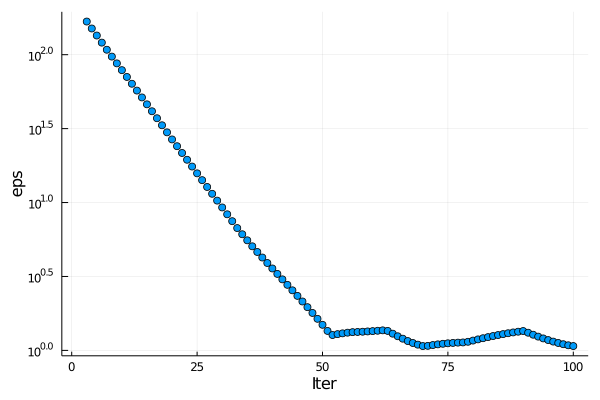

In [583]:
using Plots
to_plot = readdlm("sp_zeroT_data2.txt", Float64)
scatter(to_plot[:,1], to_plot[:,2], xlabel="Iter", ylabel="eps", yaxis=:log, label="")

In [ ]:
x0 = rand((0,1), size(H,2))
s = (-1).^x0
J = 100
init=OffsetArray(MVector{2J+1}(randn(2J+1)), -J:J)
sp = survey_propagation(H; field=s, init, y=Inf)
callback(t, ε, sp) = (println("$t $ε"); false)
iteration_zeroT_random!(sp, maxiter=100, callback=callback, damp=0.9, rein=0.0)

In [ ]:
H = sp.H
freevars = collect(1:size(H,2))
amax = argmax.(sp.survey)
σ = sign.(amax)
x = (1 .- σ).÷2
σ2 = sign.(argmax.([[s[i] for i in eachindex(s) if i != amax] for s in sp.survey]))
mag = abs.(σ-σ2)
[sort(freevars, by=i->abs(mag[i])) sort(mag)]

In [ ]:
function decimate_zeroT!(sp; decsteps=10)
    H = sp.H
    freevars = collect(1:size(H,2))
    iteration_zeroT!(sp, maxiter=500, tol=1e-5, callback=callback, damp=0.5)
    while !isempty(freevars)
        iteration_zeroT!(sp, maxiter=100, tol=1e-3, damp=0.5)
        amax = argmax.(sp.survey)
        σ = sign.(amax)
        x = (1 .- σ).÷2
        σ2 = sign.(argmax.([[s[i] for i in eachindex(s) if i != amax] for s in sp.survey]))
        mag = maximum(abs, σ-σ2)
        sort!(freevars, by=i->abs(mag[i]))
        freevars, tofix = freevars[1:end-decsteps-1], freevars[max(1,end-decsteps):end]
        println("fixing: $tofix")
        sp.efield[tofix] .= sp.J.*x[tofix]
        x = Vector(mag .< 0)
        x1 = (B*x[indep]) .% 2
        println("$(sum(H*x .%2)) $(sum(x .!= x0)/length(x)) $(sum(x1 .!= x0)/length(x)) $(length(freevars)/length(indep))")
    end
end

decimate!(sp; decsteps=50)

## Updates for variables and factors

In [537]:
b = 21
∂b = nonzeros(sp.X)[nzrange(sp.X, b)]
sp = deepcopy(sp1)
sp2 = deepcopy(sp1)
e1 = update_factor_zeroT_slow!(sp1, b; damp = 0.4)
e2 = update_factor_zeroT!(sp2, b; damp = 0.4)
[sp1.P[∂b][2] sp2.P[∂b][2]]
e1, e2

(0.0024268540099119384, 0.0024268540099119384)

In [405]:
@btime update_factor_zeroT_slow!($sp1, $b; damp = 0.4)

  1.757 ms (15907 allocations: 499.23 KiB)


4.440892098500626e-16

In [406]:
@btime update_factor_zeroT!($sp1, $b; damp = 0.4)

  17.384 μs (124 allocations: 16.98 KiB)


4.440892098500626e-16

In [67]:
i = 56
∂i = nzrange(sp.H, i)
sp = deepcopy(sp1)
e1 = update_var_zeroT_slow!(sp1, i; damp = 0.1, rein = 0.1)
e2 = update_var_zeroT!(sp, i; damp = 0.1, rein = 0.1)
[sp1.survey[i] sp.survey[i]]
[sp1.Q[∂i][2] sp.Q[∂i][2]]
# e1,e2

21×2 Array{Float64,2}:
 -Inf          -Inf
  -6.13884      -6.13884
  -2.74953      -2.74953
  -3.58529      -3.58529
  -4.19126      -4.19126
  -3.61134      -3.61134
  -2.97954      -2.97954
  -3.85339      -3.85339
  -3.40096      -3.40096
  -4.62613      -4.62613
  -4.0769       -4.0769
  -0.582046     -0.582046
  -2.87888      -2.87888
  -2.4755       -2.4755
  -1.65495      -1.65495
  -1.84256      -1.84256
  -2.59514      -2.59514
  -3.81662      -3.81662
  -1.2431       -1.2431
  -3.2986       -3.2986
   0.00263003    0.00263003

In [68]:
@btime update_var_zeroT_slow!($sp1, $i; damp = 0.4, rein = 1e-3)

  177.284 μs (4867 allocations: 145.48 KiB)


4.440892098500626e-16

In [69]:
@btime update_var_zeroT!($sp1, $i; damp = 0.4, rein = 1e-3)

  4.649 μs (19 allocations: 3.72 KiB)


4.440892098500626e-16

## Recursion for the b's

In [356]:
Q = [OffsetArray(randn(2J+1),-J:J) for _ in 1:3];

In [357]:
function Bslow(Q; k=length(Q)-1)
   b = fill(-Inf, -J:J)
    for hs in Iterators.product(fill(-J:J, k)...)
        u = minimum(abs, hs)
        σ = prod(sign, hs)
        for v in 1:u
           b[v*σ] = max(b[v*σ], sum(q[h] for (q,h) in zip(Q,hs))) 
        end
    end
    b
end

function Bfast(Q; k=length(Q)-1)
    b = fill(-Inf, -J:J); b[1:J] .= 0.0
    bnew = fill(-Inf, -J:J); bnew[1:J] .= 0.0
    for n in 1:k
        for u in 1:J
            m1 = maximum(Q[n][u:end])
            m2 = maximum(Q[n][begin:-u])
            bnew[u] = max(m1+b[u], m2+b[-u])
            bnew[-u] = max(m1+b[-u], m2+b[u])
        end
        b .= bnew
    end
    b
end

Bfast (generic function with 1 method)

In [358]:
Bsl = Bslow(Q)
Bfa = Bfast(Q)
Bsl == Bfa

true

## Recursion for the a's

In [388]:
Q = [OffsetArray(rand(2J+1),-J:J) for _ in 1:2];

In [389]:
function Aslow(Q; k=length(Q))
    a = fill(-Inf, -J:J)
    for hs in Iterators.product(fill(-J:J, k)...)
        u = minimum(abs, hs)*prod(sign, hs)
        a[u] = max(a[u], sum(q[h] for (q,h) in zip(Q,hs))) 
    end
    a
end

function Pifast(Q)
    a = Aslow(Q, k=length(Q)-1)
    b = Bslow(Q, k=length(Q)-1)
    p = fill(-Inf, -J:J)
    q = Q[end]
    for u in 1:J-1
        m1 = maximum(q[u+1:end])
        m2 = maximum(q[begin:-u-1])
        p[u] = max(q[u]+b[u], q[-u]+b[-u], m1+a[u], m2+a[-u])
        p[-u] = max(q[u]+b[-u], q[-u]+b[u], m1+a[-u], m2+a[u])
    end
    p[J] = max(q[J]+b[J], q[-J]+b[-J])
    p[-J] = max(q[J]+b[-J], q[-J]+b[J])
    # u=0
    sumqstar = 0.0
    qmax = -Inf
    for j in 1:length(Q)
        qstar = maximum(Q[j])
        sumqstar += qstar
        qmax = max(qmax, Q[j][0] - qstar)
    end
    p[0] = sumqstar + qmax
    p
end
    
function Afast(Q, k=length(Q))
    p = fill(-Inf, -J:J)
    b = fill(-Inf, -J:J); b[1:J] .= 0.0
    pnew = fill(-Inf, -J:J)
    bnew = fill(-Inf, -J:J); bnew[1:J] .= 0.0
    sumqstar = 0.0
    qmax = -Inf
    for j in 1:k
        q = Q[j]
        # update for u=0
        qstar = maximum(q)
        sumqstar += qstar
        qmax = max(qmax, q[0] - qstar)
        # update p and b
        for u in 1:J-1
            m1 = maximum(q[u+1:end])
            m2 = maximum(q[begin:-u-1])
            pnew[u] = max(q[u]+b[u], q[-u]+b[-u], m1+p[u], m2+p[-u])
            pnew[-u] = max(q[u]+b[-u], q[-u]+b[u], m1+p[-u], m2+p[u])
            n1 = max(m1, q[u])
            n2 = max(m2, q[-u])
            bnew[u] = max(n1+b[u], n2+b[-u])
            bnew[-u] = max(n1+b[-u], n2+b[u])
        end
        pnew[J] = bnew[J] = max(q[J]+b[J], q[-J]+b[-J])
        pnew[-J] = bnew[-J] = max(q[J]+b[-J], q[-J]+b[J])
        b .= bnew
        p .= pnew
    end
    p[0] = sumqstar + qmax
    p        
end
    
function Afast_old(Q, k=length(Q))
    a = fill(-Inf, -J:J)
    b = fill(-Inf, -J:J); b[1:J] .= 0.0
    anew = fill(-Inf, -J:J)
    bnew = fill(-Inf, -J:J); bnew[1:J] .= 0.0
    for n in 1:k
        q = Q[n]
        # update a
        for u in 1:J-1
            m1 = maximum(q[u+1:end])
            m2 = maximum(q[begin:-u-1])
            anew[u] = max(q[u]+b[u], q[-u]+b[-u], m1+a[u], m2+a[-u])
            anew[-u] = max(q[u]+b[-u], q[-u]+b[u], m1+a[-u], m2+a[u])
        end
        anew[J] = max(q[J]+b[J], q[-J]+b[-J])
        anew[-J] = max(q[J]+b[-J], q[-J]+b[J])
        # update b
        for u in 1:J
            m1 = maximum(q[u:end])
            m2 = maximum(q[begin:-u])
            bnew[u] = max(m1+b[u], m2+b[-u])
            bnew[-u] = max(m1+b[-u], m2+b[u])
        end
        b .= bnew
        a .= anew
    end
    a        
end

Afast_old (generic function with 2 methods)

In [390]:
Asl = Aslow(Q, k=length(Q))
Pfast = Pifast(Q)
Afa = Afast(Q)
[Asl Pfast Afa]

21×3 Array{Float64,2}:
 0.999569  0.999569  0.999569
 1.18077   1.18077   1.18077
 1.50147   1.50147   1.50147
 1.76321   1.76321   1.76321
 1.5637    1.5637    1.5637
 1.70259   1.70259   1.70259
 1.78917   1.78917   1.78917
 1.83508   1.83508   1.83508
 1.63741   1.63741   1.63741
 1.73482   1.73482   1.73482
 1.67677   1.67677   1.67677
 1.77491   1.77491   1.77491
 1.61045   1.61045   1.61045
 1.80812   1.80812   1.80812
 1.77844   1.77844   1.77844
 1.79017   1.79017   1.79017
 1.47612   1.47612   1.47612
 1.67563   1.67563   1.67563
 1.59641   1.59641   1.59641
 1.14453   1.14453   1.14453
 1.07134   1.07134   1.07134

## Max-Sum convolution for variable update

In [231]:
function msc_slow(P, J=10, s=1)
    Pnew = copy(P[2:end])
    f = min(-J, sum(firstindex(p) for p in Pnew)+s)
    l = max(J,sum(lastindex(p) for p in Pnew)+s)
    q = fill(Inf, f:l)
    for us in Iterators.product(fill(-J:J, length(Pnew))...)
        h = sum(us) + s
        q[h] = min(q[h],abs(h) - sum(abs.(u)+p[u] for (p,u) in zip(Pnew,us)))
    end
    replace!(q, Inf => -Inf)
    # clamp
    q[J] = maximum(q[J:end])
    q[-J] = maximum(q[begin:-J])
    q[-J:J]
end

function msc_fast(P, J=10, s=1)
    Pnew = [abs.(OffsetArray(-J:J, -J:J)) + p for p in P[2:end]]
    f = fill(0.0, s:s)
    for n in eachindex(Pnew)
        f = msc(f, Pnew[n])
    end  
    q = fill(-Inf, -J:J)
    for h in eachindex(f)
        q[clamp(h,-J,J)] = max(q[clamp(h,-J,J)], abs(h) - f[h])
    end
        @show q_fast=q
    q  
end
    
function msc_faster(P, J=10, s=1)
    Pnew = [abs.(OffsetArray(-J:J, -J:J)) + p for p in P[2:end]]
    init = fill(0.0, s:s)
    Q = [fill(0.0, 0:0) for a ∈ 1:length(Pnew)]
    f = cavity!(Q, Pnew, msc, init)
    q = fill(-Inf, -J:J)
    for h in eachindex(f)
        q[clamp(h,-J,J)] = max(q[clamp(h,-J,J)], abs(h) - f[h])
    end
    @show q_faster = q
    q
end

msc_faster (generic function with 3 methods)